# MNIST images classification using Keras: baseline
1- MNIST dataset in memory  
2- Feed data using tf.data.dataset API  
3- Model using tf.keras API  
4- Local training and testing using tf.keras API  
5- Use TensorBoard to monitor training  
6- Monitor loss and accuracy
7- Save the model

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [4]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
   workingdir=str(pathlib.Path(workingdir).parents[0])
   print(workingdir)
   d=[d for d in os.listdir(str(workingdir))]
   n+=1
   if n>5:
       break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import _pickle as cPickle
import shutil
import time
import glob
import re

In [6]:
print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


### Import our utils functions

In [7]:
import src.utils.mnist_utils as mnist_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_v1.trainer.model as mnist_v1

In [8]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [9]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [10]:
plt.style.use('seaborn-ticks')

## Input Data
### Load the data

In [11]:
# load the data: path is relative to the python path!
(x_train, y_train), (x_test, y_test) = mnist_utils.load_data(path='data/mnist/raw/mnist.pkl.gz')

### Basics checks

In [12]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [13]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [14]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [15]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

### Size of the data

In [16]:
print('{0:.2f} Mb'.format(x_test.nbytes/1024.0**2))

7.48 Mb


In [17]:
print('{0:.2f} Mb'.format(x_train.nbytes/1024.0**2))

44.86 Mb


In [18]:
print('{0:.2f} Mb'.format(y_test.nbytes/1024.0**2))

0.01 Mb


In [19]:
print('{0:.2f} Mb'.format(y_train.nbytes/1024.0**2))

0.06 Mb


### Saving the data as pickle files

In [17]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
cPickle.dump(x_train, open(path_train+'x_train.pkl', 'wb'))
cPickle.dump(y_train, open(path_train+'y_train.pkl', 'wb'))
cPickle.dump(x_test, open(path_test+'x_test.pkl', 'wb'))
cPickle.dump(y_test, open(path_test+'y_test.pkl', 'wb'))

## Visualize the data

### Some example from training dataset

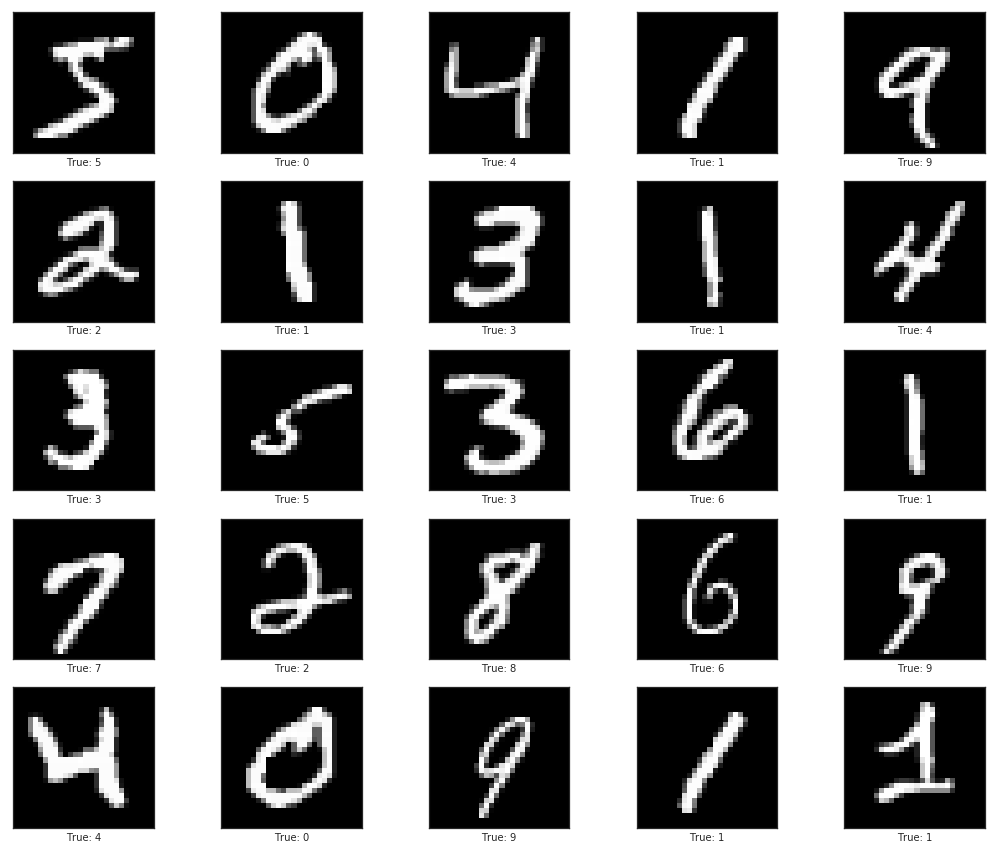

In [20]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

### Some example from testing dataset

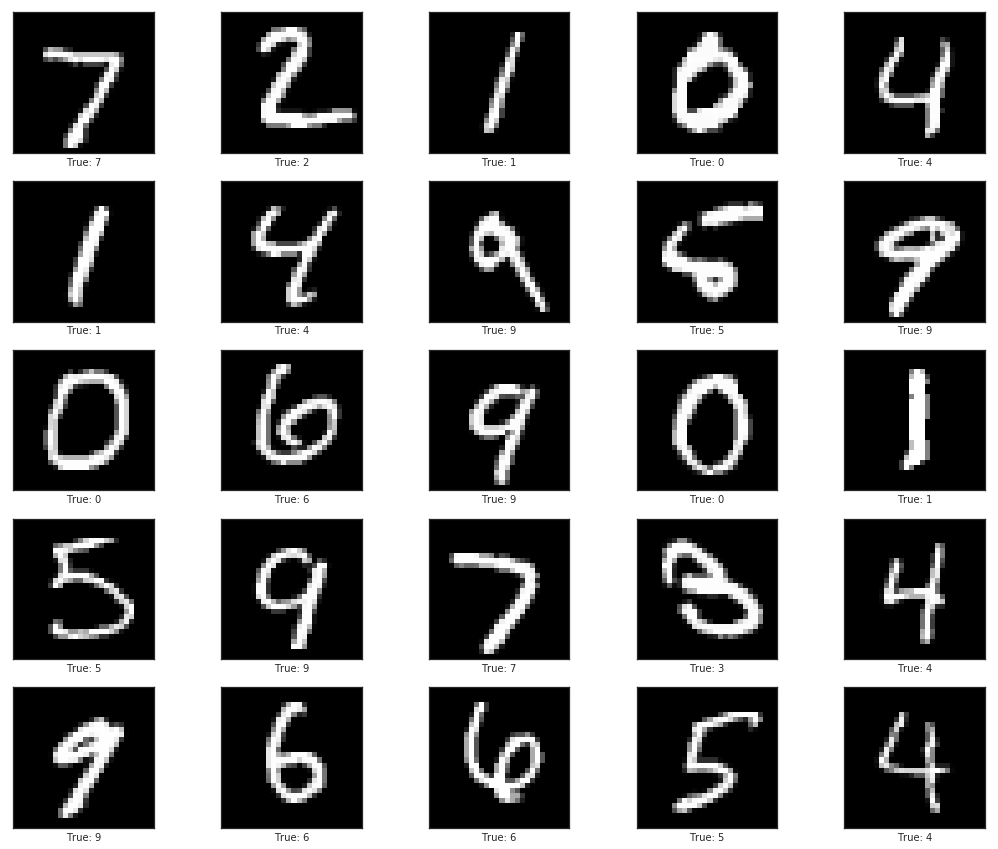

In [21]:
mnist_utils.plot_mnist_images(x_test[0:25], y_test[0:25])

## Set parameters

In [22]:
tf.logging.set_verbosity(tf.logging.INFO)

In [23]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 10

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model version
MODEL='v1'

## Defined flags

In [24]:
tensorflow_helper.del_all_flags(tf.flags.FLAGS)

In [25]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('f', '', 'kernel') 

# path to store the model and input for Tensorboard
tf.app.flags.DEFINE_string('model_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/ckpt/', 'Dir to save a model and checkpoints with keras')
tf.app.flags.DEFINE_string('tensorboard_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/logs/', 'Dir to save logs for TensorBoard with keras')

# parameters for the input dataset and train the model
tf.app.flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
tf.app.flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
tf.app.flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
tf.app.flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = tf.app.flags.FLAGS

## Input dataset
Use tf.data.dataset to feed the Keras model

### Input dataset functions for training
Load, convert, preprocess and reshuffle the images and labels 

In [26]:
training_dataset = mnist_v1.input_mnist_array_dataset_fn(x_train, 
                                                         y_train, 
                                                         FLAGS,
                                                         mode=tf.estimator.ModeKeys.TRAIN, 
                                                         batch_size=FLAGS.batch_size)

INFO:tensorflow:input_dataset_fn: TRAIN, train


### Input dataset functions for testing
Load, convert, preprocess and reshuffle the images and labels 

In [27]:
testing_dataset = mnist_v1.input_mnist_array_dataset_fn(x_test, 
                                                        y_test,
                                                        FLAGS,
                                                        mode=tf.estimator.ModeKeys.EVAL, 
                                                        batch_size=len(x_test))

INFO:tensorflow:input_dataset_fn: EVAL, eval


### Printing the number relater to the number of events (epoch, batch size, ...)

In [29]:
def print_summary_input(data, step='training'):
    print('Summary for the {} dataset:'.format(step))
    if step=='training':
        print('  - number of epoch            :', FLAGS.epoch)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', FLAGS.batch_size)
        print('  - number of step per epoch   :', FLAGS.step_per_epoch)
        print('  - total number of steps      :', FLAGS.epoch * FLAGS.step_per_epoch)
    else:
        print('  - number of epoch            :', 1)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', None)
        print('  - number of step per epoch   :', 1)
        print('  - total number of steps      :', 1)  

In [30]:
print_summary_input(x_train)

Summary for the training dataset:
  - number of epoch            : 10
  - number of events per epoch : 60000
  - batch size                 : 128
  - number of step per epoch   : 468
  - total number of steps      : 4680


In [31]:
print_summary_input(x_test, 'testing')

Summary for the testing dataset:
  - number of epoch            : 1
  - number of events per epoch : 10000
  - batch size                 : None
  - number of step per epoch   : 1
  - total number of steps      : 1


## Build the Machine Learning model using Keras

### Build the model

In [32]:
print('trained model will be saved here:\n',FLAGS.model_dir_keras)

trained model will be saved here:
 ./results/Models/Mnist/tf_1_12/keras/v1/ckpt/


In [33]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.model_dir_keras, ignore_errors=True)

In [34]:
def baseline_model(opt='tf'):
    
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(512, 
                    input_dim=FLAGS.dim_input,
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(512,  
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
        
    # last layer
    model.add(tf.keras.layers.Dense(FLAGS.num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    if opt=='keras':
        optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
        # GD/SGC:   keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
        # Adam:     keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        # RMSProp:  keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
        # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    else:
        #optimiser (use tf.train and not tf.keras to use MirrorStrategy)
        # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
        optimiser=tf.train.AdamOptimizer #(learning_rate=0.001, beta1=0.9)
        # GD/SGC:   tf.train.GradientDescentOptimizer(learning_rate, use_locking=False, name='GradientDescent') 
        # Adam:     tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,name='Adam')
        # RMSProp:  tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
        # Momentum: tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum', use_nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [35]:
# reset the model
tf.keras.backend.clear_session()

In [36]:
# build the model
model_opt_keras = baseline_model(opt='keras')

# store the origina weights
initial_weights = model_opt_keras.get_weights()

### Check the nuber of parameters

In [37]:
model_opt_keras.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [38]:
model_opt_keras.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [39]:
model_opt_keras.output_names

['dense_2']

## Adding some actions during the training
We use for that call back with Keras

### TensorBoard

In [40]:
print('Tensorflow logs will be saved here:\n',FLAGS.tensorboard_dir_keras)

Tensorflow logs will be saved here:
 ./results/Models/Mnist/tf_1_12/keras/v1/logs/


In [41]:
# look a the list of existing files
for file in glob.glob(FLAGS.tensorboard_dir_keras+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1552832110.Fabien-Tarrades-MacBook-Pro.local


In [42]:
# remove the files
shutil.rmtree(FLAGS.tensorboard_dir_keras ,ignore_errors=True)

In [43]:
tbCallBack=tf.keras.callbacks.TensorBoard(log_dir=FLAGS.tensorboard_dir_keras, 
                                          histogram_freq=1, 
                                          write_graph=True)

## Training the model
We use  Keras and feed data to our model using tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.

### Fit the model using Keras and tf.data.dataset

In [44]:
%%time
# set to the original weights for testing other pipelines
model_opt_keras.set_weights(initial_weights)

# fit the model (using data.Dataset)
history=model_opt_keras.fit(training_dataset.make_one_shot_iterator(),                # use training dataset
                            steps_per_epoch=FLAGS.step_per_epoch,                     # number of train step per epoch
                            validation_data=testing_dataset.make_one_shot_iterator(), # use testing dataset
                            validation_steps=1,                                       # number of test step per epoch
                            callbacks=[tbCallBack],                                   # activate TensorBoard
                            epochs=FLAGS.epoch,                                       # number of epoch for training
                            verbose = 1)

Epoch 1/10
468/468 [==============================] - 21s 46ms/step - loss: 0.3240 - acc: 0.9072 - val_loss: 0.1893 - val_acc: 0.9467
Epoch 2/10
468/468 [==============================] - 16s 34ms/step - loss: 0.2392 - acc: 0.9363 - val_loss: 0.1785 - val_acc: 0.9570
Epoch 3/10
468/468 [==============================] - 17s 37ms/step - loss: 0.2374 - acc: 0.9400 - val_loss: 0.1652 - val_acc: 0.9598
Epoch 4/10
468/468 [==============================] - 16s 34ms/step - loss: 0.2234 - acc: 0.9452 - val_loss: 0.1431 - val_acc: 0.9629
Epoch 5/10
468/468 [==============================] - 17s 35ms/step - loss: 0.2076 - acc: 0.9487 - val_loss: 0.1542 - val_acc: 0.9665
Epoch 6/10
468/468 [==============================] - 16s 34ms/step - loss: 0.2102 - acc: 0.9488 - val_loss: 0.1647 - val_acc: 0.9653
Epoch 7/10
468/468 [==============================] - 16s 35ms/step - loss: 0.1933 - acc: 0.9540 - val_loss: 0.1737 - val_acc: 0.9655
Epoch 8/10
468/468 [==============================] - 16s 35ms

### Monitoring using TensorBoard

In [42]:
# copy the following in the shell
'tensorboard --logdir  '+'"'+FLAGS.tensorboard_dir_keras+'"'

'tensorboard --logdir  "./results/Models/Mnist/tf_1_12/keras/v1/logs/"'

### Validation plot after training

Loss:
  - loss [training dataset]: 0.173
  - loss [validation dataset: 0.152

Accuracy:
  - accuracy [training dataset]: 95.73%
  - accuracy [validation dataset: 96.58%


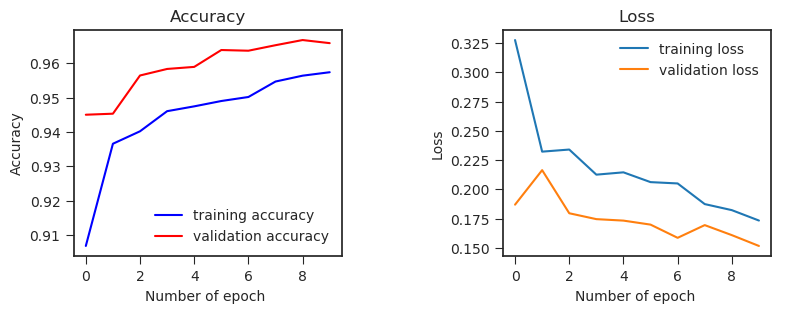

In [73]:
mnist_utils.plot_acc_loss(history, FLAGS.epoch)

### Save the model using Keras

In [74]:
# with keras optimiser we can save the model+weight
if not os.path.exists(FLAGS.model_dir_keras):
    os.makedirs(FLAGS.model_dir_keras)
model_opt_keras.save(FLAGS.model_dir_keras+'keras_model.h5')

### Checking Tensorboard input files

In [75]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}
    
    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [76]:
history_tfb=load_data_tensorboard(FLAGS.tensorboard_dir_keras)

INFO:tensorflow:No path found after ./results/Models/Mnist/tf_1_12/keras/v1/logs/events.out.tfevents.1552832110.Fabien-Tarrades-MacBook-Pro.local


In [77]:
print(load_data_tensorboard(FLAGS.tensorboard_dir_keras))

INFO:tensorflow:No path found after ./results/Models/Mnist/tf_1_12/keras/v1/logs/events.out.tfevents.1552832110.Fabien-Tarrades-MacBook-Pro.local
{'batch_acc': (array([   0,    1,    2, ..., 4677, 4678, 4679]), array([0.125    , 0.1640625, 0.328125 , ..., 0.9765625, 0.9609375,
       0.9765625])), 'batch_loss': (array([   0,    1,    2, ..., 4677, 4678, 4679]), array([2.41165924, 3.92753887, 3.6730125 , ..., 0.06146329, 0.12912087,
       0.07850966])), 'epoch_acc': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0.90686768, 0.93656516, 0.94018763, 0.94603032, 0.94743258,
       0.94898504, 0.95015359, 0.95464408, 0.95634681, 0.95734841])), 'epoch_loss': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0.32760292, 0.23225561, 0.23404117, 0.21259154, 0.21456924,
       0.20620978, 0.20507887, 0.18744138, 0.1822715 , 0.17337635])), 'epoch_val_acc': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0.94499999, 0.94529998, 0.95639998, 0.95829999, 0.95889997,
       0.96380001, 0.96359998, 0.9652

In [80]:
history_tfb.keys()

dict_keys(['batch_acc', 'batch_loss', 'epoch_acc', 'epoch_loss', 'epoch_val_acc', 'epoch_val_loss'])